# Binary classification example using the malaria dataset

This notebook uses the malaria dataset from tensorflow.datasets
https://www.tensorflow.org/datasets/catalog/malaria

In [1]:
# import required libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds



#Loading and preparing data

In [2]:
# load malaria dataset using Tensorflow Datasets
# split the data into train(70%), validation(10%) and test(20%) datasets
(train_ds, valid_ds, test_ds), ds_info = tfds.load('malaria', split = ['train[:70%]', 'train[70%:80%]', 'train[80%:]'],
                                                   as_supervised = True, shuffle_files = True, with_info = True)
assert isinstance(train_ds, tf.data.Dataset)
print(len(train_ds), len(test_ds))


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteNHTKF6/malaria-train.tfrecord


  0%|          | 0/27558 [00:00<?, ? examples/s]

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
19291 5512


In [3]:
# get class names
class_names = ds_info.features['label'].names

(103, 103, 3) uninfected
(145, 148, 3) uninfected
(133, 127, 3) uninfected
(118, 118, 3) parasitized
(124, 121, 3) uninfected
(151, 148, 3) parasitized
(151, 130, 3) parasitized
(139, 175, 3) uninfected
(151, 139, 3) parasitized
(160, 148, 3) parasitized
(124, 130, 3) uninfected
(133, 136, 3) uninfected
(145, 163, 3) parasitized
(112, 115, 3) parasitized
(133, 133, 3) parasitized
(166, 184, 3) parasitized


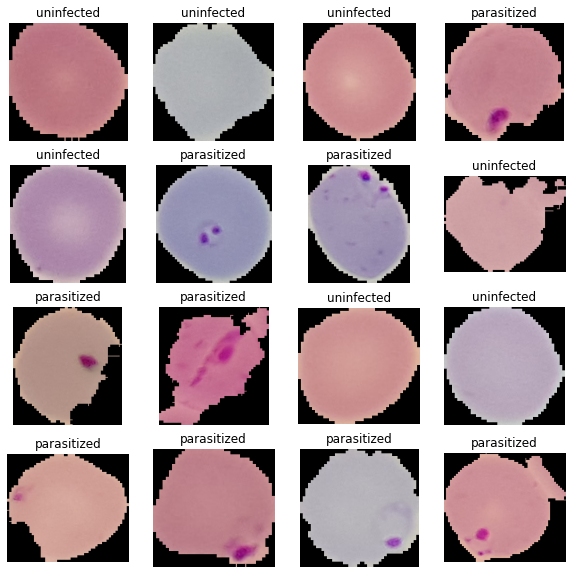

In [4]:
# View some samples
ds = train_ds.take(16)
plt.figure(figsize = (10,10))
for n, example in enumerate(ds):
    plt.subplot(4,4,n + 1)
    image = example[0]
    label = example[1]
    print(image.shape, class_names[label])
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis("off")
plt.show()



In [5]:
# Preprocessing: resize and normalize images 
IMG_SIZE = 196
def resize_and_rescale(image):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image/255.0
    return image

train_ds = train_ds.map(lambda x,y: (resize_and_rescale(x), y))
valid_ds = valid_ds.map(lambda x,y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x,y: (resize_and_rescale(x), y))



In [6]:
# Prepare datasets: batch and prefetch
train_ds = train_ds.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)



# Model 0: multi-layer perceptron

In [7]:
# Build first model
inputs = tf.keras.layers.Input(shape = (IMG_SIZE, IMG_SIZE, 3), name = "input_layer")

x = tf.keras.layers.Dense(50, activation = "relu")(inputs)
x = tf.keras.layers.Dense(25, activation = "relu")(x)
x = tf.keras.layers.Flatten()(x)

outputs = tf.keras.layers.Dense(1, activation = "sigmoid")(x)

model_0 = tf.keras.Model(inputs, outputs)


In [8]:
# Compile model
model_0.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                loss = tf.keras.losses.binary_crossentropy,
                metrics = ["accuracy"])

model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 196, 196, 3)]     0         
_________________________________________________________________
dense (Dense)                (None, 196, 196, 50)      200       
_________________________________________________________________
dense_1 (Dense)              (None, 196, 196, 25)      1275      
_________________________________________________________________
flatten (Flatten)            (None, 960400)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 960401    
Total params: 961,876
Trainable params: 961,876
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Set up early stopping callback to stop training when the model stops learning
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 1, restore_best_weights = True)

In [10]:
#Fit model
history_0 = model_0.fit(train_ds,
                    epochs = 100,
                    validation_data = valid_ds,
                    callbacks = [early_stopping])

Epoch 1/100
603/603 [==============================] - 67s 106ms/step - loss: 0.6558 - accuracy: 0.6385 - val_loss: 0.6177 - val_accuracy: 0.6475
Epoch 2/100
603/603 [==============================] - 64s 106ms/step - loss: 0.5673 - accuracy: 0.7087 - val_loss: 0.5698 - val_accuracy: 0.6966
Epoch 3/100
603/603 [==============================] - 64s 106ms/step - loss: 0.5087 - accuracy: 0.7652 - val_loss: 0.4811 - val_accuracy: 0.7949
Epoch 4/100
603/603 [==============================] - 64s 106ms/step - loss: 0.4661 - accuracy: 0.8040 - val_loss: 0.4505 - val_accuracy: 0.8200
Epoch 5/100
603/603 [==============================] - 64s 105ms/step - loss: 0.4350 - accuracy: 0.8289 - val_loss: 0.4267 - val_accuracy: 0.8399
Epoch 6/100
603/603 [==============================] - 64s 106ms/step - loss: 0.4109 - accuracy: 0.8477 - val_loss: 0.4039 - val_accuracy: 0.8544
Epoch 7/100
603/603 [==============================] - 64s 106ms/step - loss: 0.3895 - accuracy: 0.8625 - val_loss: 0.3823 -

In [14]:
# evaluate model 0 using test data
model_0.evaluate(test_ds)

173/173 [==============================] - 8s 47ms/step - loss: 0.3433 - accuracy: 0.8855


[0.3433198928833008, 0.8855224847793579]

In [22]:
# function to plot model accuracy and loss curves
def plot_accuracy_loss_curves(history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize =(10,5))

  plt.subplot(1,2,1)
  plt.plot(accuracy)
  plt.plot(val_accuracy)
  plt.legend(['accuracy', 'validation accuracy'])
  plt.xlabel('epoch')
  plt.ylabel('accuracy')

  plt.subplot(1,2,2)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['loss', 'validation loss'])
  plt.xlabel('epoch')
  plt.ylabel('loss')



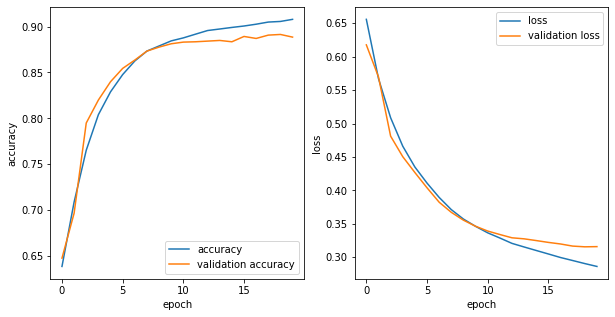

In [25]:
# plot model_0 loss and accuracy curves
plot_accuracy_loss_curves(history_0)

# Model 1: convolutional neural network

In [20]:
# create model
inputs = tf.keras.layers.Input(shape = (IMG_SIZE, IMG_SIZE, 3), name = "input_layer")
x = tf.keras.layers.Conv2D(filters = 12, kernel_size = (5,5), activation = "relu")(inputs)
x = tf.keras.layers.Conv2D(filters = 12, kernel_size = (5,5), activation = "relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters = 12, kernel_size = (5,5), activation = "relu")(x)
x = tf.keras.layers.Conv2D(filters = 12, kernel_size = (5,5), activation = "relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(1, activation = "sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs)

# compile model
model_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                loss = tf.keras.losses.binary_crossentropy,
                metrics = ["accuracy"])

# display model summary
model_1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 196, 196, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 192, 192, 12)      912       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 188, 188, 12)      3612      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 94, 94, 12)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 90, 90, 12)        3612      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 86, 86, 12)        3612      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 43, 43, 12)        0   

In [21]:
#Fit model
history_1 = model_1.fit(train_ds,
                      epochs = 100,
                      validation_data = valid_ds,
                      callbacks = [early_stopping])

Epoch 1/100
603/603 [==============================] - 56s 90ms/step - loss: 0.6380 - accuracy: 0.6293 - val_loss: 0.6419 - val_accuracy: 0.6113
Epoch 2/100
603/603 [==============================] - 53s 87ms/step - loss: 0.5574 - accuracy: 0.7205 - val_loss: 0.5144 - val_accuracy: 0.7535
Epoch 3/100
603/603 [==============================] - 53s 88ms/step - loss: 0.3190 - accuracy: 0.8790 - val_loss: 0.2305 - val_accuracy: 0.9347
Epoch 4/100
603/603 [==============================] - 53s 87ms/step - loss: 0.2052 - accuracy: 0.9324 - val_loss: 0.1787 - val_accuracy: 0.9445
Epoch 5/100
603/603 [==============================] - 52s 87ms/step - loss: 0.1837 - accuracy: 0.9415 - val_loss: 0.1684 - val_accuracy: 0.9463
Epoch 6/100
603/603 [==============================] - 53s 87ms/step - loss: 0.1746 - accuracy: 0.9445 - val_loss: 0.1642 - val_accuracy: 0.9492
Epoch 7/100
603/603 [==============================] - 52s 87ms/step - loss: 0.1696 - accuracy: 0.9459 - val_loss: 0.1605 - val_ac

In [185]:
# evaluate model 1 using test data
model_1.evaluate(test_ds)

173/173 [==============================] - 8s 45ms/step - loss: 0.1795 - accuracy: 0.9472


[0.17945224046707153, 0.9472060799598694]

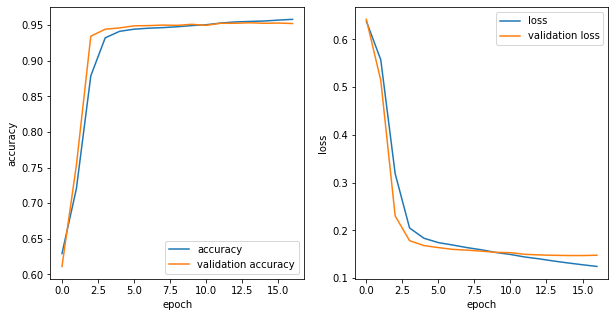

In [186]:
# plot accuracy and loss curves for model 1
plot_accuracy_loss_curves(history_1)

# Analyze model_1 predictions

In [117]:
# get model_1 predictions and true values
true_values = []
predictions = []
images = []
for image, label in test_ds.take(-1):
  true_values.append(label)
  predictions.append(tf.round(model_1.predict(image)))
  images.append(image)

true_values = np.concatenate(true_values)
predictions = np.squeeze(np.concatenate(predictions))
images = np.concatenate(images)

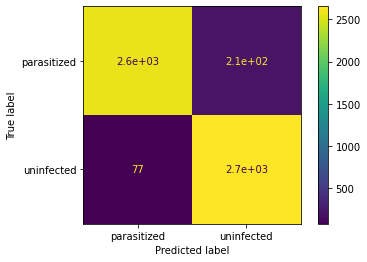

In [121]:
# plot model confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_values, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels = class_names)
disp.plot()

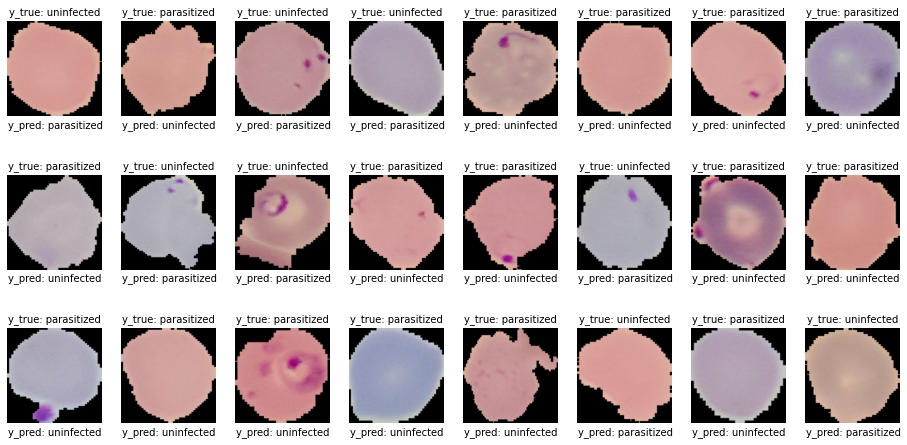

In [180]:
# visualize some wrong predictions
import random
wrong_preds = (true_values[true_values != predictions], predictions[true_values != predictions])
wrong_images = images[true_values != predictions]

random_indexes = random.sample(range(0, len(wrong_images)), 24)

plt.figure(figsize = (16, 8))

for n, index in enumerate(random_indexes):
  plt.subplot(3, 8, n + 1)
  plt.imshow(images[index])
  plt.axis("off")
  true_label = class_names[int(wrong_preds[0][index])]
  prediction = class_names[int(wrong_preds[1][index])]
  plt.title(f"y_true: {true_label}", fontdict = {'fontsize' : 10})
  plt.text( 0.5, 220, s = f"y_pred: {prediction}")